In [5]:
import pandas as pd

# Load the Excel file
file_path = 'Data.csv'  # Replace with your actual file path
df = pd.read_csv(file_path)

# Display the first few rows
print(df.head())


   inflation                total-supply                      bonded  \
0     387000  30260413831987256828836706  12567535604355922512661056   
1     387500  30271872178542880954510367  12569514693879571699473418   
2     388500  30294970264150980574224800  12586003764524060908494305   
3     389000  30306614246638292772927654  12603390991796358096866368   
4     389500  30318147816884488859432816  12617978678136175242735481   

   participation-rate  issuance-rate        date  btc_price_usd  \
0            0.415313       0.141255  2024-01-01   44167.332031   
1            0.415221       0.141437  2024-01-02   44957.968750   
2            0.415449       0.141802  2024-01-03   42848.175781   
3            0.415863       0.141985  2024-01-04   44179.921875   
4            0.416186       0.142168  2024-01-05   44162.691406   

   eth_price_usd  lpt_price_usd   btc_volume   eth_volume  lpt_volume  \
0    2352.327881       8.278921  18426978443   6906765990    30206719   
1    2355.836426  

In [68]:
import numpy as np
import pandas as pd
from scipy import stats

def simple_inflation_fng_analysis(df, fear_thr=25, greed_thr=75, window=3, winsor=(0.01, 0.99)):
    df = df.copy()

    # 1) Basic cleaning
    if "date" in df.columns and not isinstance(df.index, pd.DatetimeIndex):
        df["date"] = pd.to_datetime(df["date"], errors="coerce", utc=True)
        df = df.set_index("date")
    df = df.sort_index()
    df = df[["I","fng"]].dropna()

    # Optional: winsorize mild outliers to stabilize dI
    #for c in ["I","fng"]:
    #    lo, hi = df[c].quantile(winsor)
    #    df[c] = df[c].clip(lo, hi)

    # 2) Compute issuance changes
    df["dI"] = df["I"].diff()
    df = df.dropna()

    # 3) Extreme flags
    df["ext_fear"]  = (df["fng"] <= fear_thr).astype(int)
    df["ext_greed"] = (df["fng"] >= greed_thr).astype(int)

    # 4) Build simple post-event windows (no look-ahead leakage)
    def mark_window(flag_col):
        m = pd.Series(0, index=df.index)
        idxs = df.index[df[flag_col]==1]
        for t in idxs:
            # from t to t+window
            loc = df.index.get_loc(t)
            if isinstance(loc, slice): loc = loc.start
            end = min(len(df)-1, loc + window)
            m.iloc[loc:end+1] = 1
        return m

    df["fear_win"]  = mark_window("ext_fear")
    df["greed_win"] = mark_window("ext_greed")
    normal_mask = (df["fear_win"]==0) & (df["greed_win"]==0)

    # 5) Directional probabilities & magnitudes
    # Direction: "issuance steps up" => dI > 0 ; "steps down" => dI < 0
    p_up_after_fear    = (df.loc[df["fear_win"]==1,  "dI"] > 0).mean()
    p_down_after_greed = (df.loc[df["greed_win"]==1, "dI"] < 0).mean()
    p_up_normal        = (df.loc[normal_mask, "dI"] > 0).mean()
    p_down_normal      = (df.loc[normal_mask, "dI"] < 0).mean()

    # Magnitudes (absolute changes)
    mag_fear   = df.loc[df["fear_win"]==1,  "dI"].abs()
    mag_greed  = df.loc[df["greed_win"]==1, "dI"].abs()
    mag_normal = df.loc[normal_mask,         "dI"].abs()

    # Nonparametric checks (Mann-Whitney U) for |dI|
    def mwu(a, b):
        if len(a)==0 or len(b)==0:
            return np.nan, np.nan
        u = stats.mannwhitneyu(a, b, alternative="two-sided")
        return float(u.statistic), float(u.pvalue)

    u_fear, p_fear   = mwu(mag_fear,  mag_normal)
    u_greed, p_greed = mwu(mag_greed, mag_normal)

    # 6) Simple rank correlations
    spear_I   = stats.spearmanr(df["I"],  df["fng"], nan_policy="omit").correlation
    spear_dI  = stats.spearmanr(df["dI"], df["fng"], nan_policy="omit").correlation

    # 7) Compact Results Panel
    panel = pd.DataFrame({
        "metric": [
            "P( dI>0 | post-FEAR )", "P( dI>0 | NORMAL )",
            "P( dI<0 | post-GREED )","P( dI<0 | NORMAL )",
            "E[|dI| | post-FEAR ]",  "E[|dI| | post-GREED ]", "E[|dI| | NORMAL ]",
            "MWU |dI| FEAR vs NORMAL (p)", "MWU |dI| GREED vs NORMAL (p)",
            "Spearman( I , FNG )",   "Spearman( dI , FNG )"
        ],
        "value": [
            p_up_after_fear, p_up_normal,
            p_down_after_greed, p_down_normal,
            mag_fear.mean() if len(mag_fear)>0 else np.nan,
            mag_greed.mean() if len(mag_greed)>0 else np.nan,
            mag_normal.mean() if len(mag_normal)>0 else np.nan,
            p_fear, p_greed,
            spear_I, spear_dI
        ]
    })

    return {
        "panel": panel,
        "spearman_I_fng": float(spear_I) if pd.notna(spear_I) else np.nan,
        "spearman_dI_fng": float(spear_dI) if pd.notna(spear_dI) else np.nan,
        "thresholds": {"fear_thr": fear_thr, "greed_thr": greed_thr, "window_days": window}
    }

# --- Example usage ---
df = pd.read_csv("DATA.csv")
df = df.rename(columns={'participation-rate': 'B', 'issuance-rate': 'I', 'fear-greed-index': 'fng'})
out = simple_inflation_fng_analysis(df, fear_thr=25, greed_thr=80, window=3)
print(out["panel"])
print("Thresholds used:", out["thresholds"])


                          metric     value
0          P( dI>0 | post-FEAR )  1.000000
1             P( dI>0 | NORMAL )  1.000000
2         P( dI<0 | post-GREED )  0.000000
3             P( dI<0 | NORMAL )  0.000000
4           E[|dI| | post-FEAR ]  0.000213
5          E[|dI| | post-GREED ]  0.000207
6              E[|dI| | NORMAL ]  0.000204
7    MWU |dI| FEAR vs NORMAL (p)  0.682699
8   MWU |dI| GREED vs NORMAL (p)  0.141403
9            Spearman( I , FNG ) -0.020227
10          Spearman( dI , FNG )  0.004954
Thresholds used: {'fear_thr': 25, 'greed_thr': 80, 'window_days': 3}


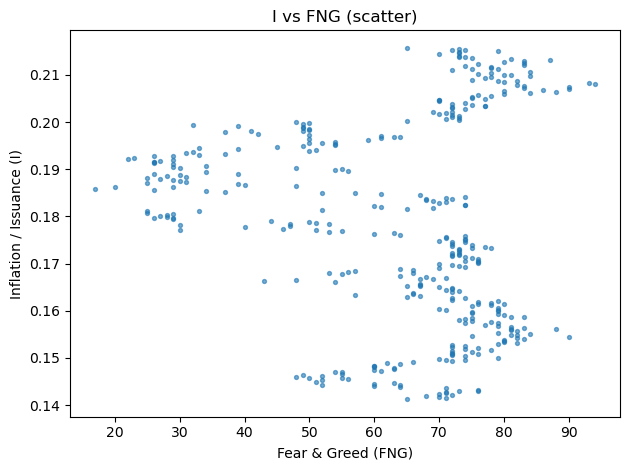

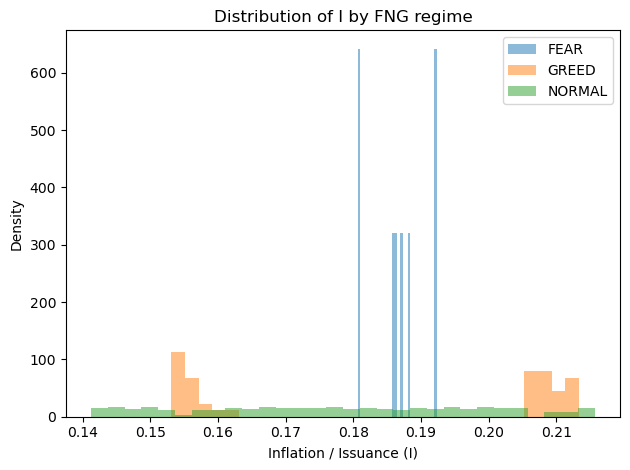

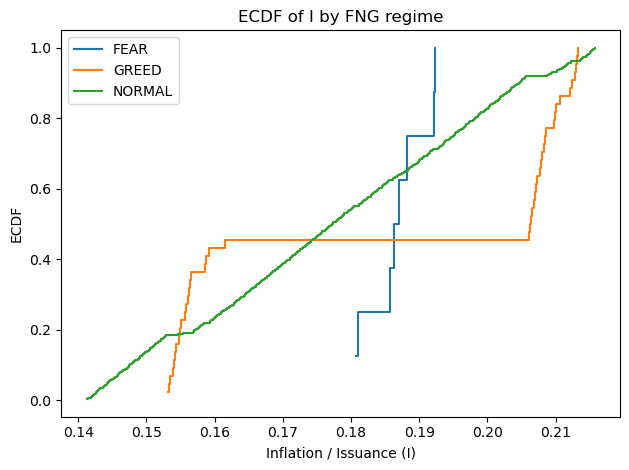

In [59]:

### PLots

import matplotlib.pyplot as plt

def plot_scatter_I_vs_fng(df: pd.DataFrame):
    fig = plt.figure()
    plt.scatter(df["fng"], df["I"], s=8, alpha=0.6)
    plt.xlabel("Fear & Greed (FNG)")
    plt.ylabel("Inflation / Issuance (I)")
    plt.title("I vs FNG (scatter)")
    plt.tight_layout()

def plot_distributions_I_by_FNG_regime(
    df,
    fear_thr=25, greed_thr=75,       # or use quantiles below
    winsor=(0.01,0.99),
    use_quantiles=False, fear_q=0.10, greed_q=0.90,
    show_ecdf=True
):
    """
    Plots histograms (and optional ECDFs) of inflation I for FEAR, GREED, and NORMAL FNG regimes.
    """
    d = df.copy() #_prep(df, cols=("I","fng"), winsor=winsor)

    if use_quantiles:
        fear_thr  = float(d["fng"].quantile(fear_q))
        greed_thr = float(d["fng"].quantile(greed_q))

    fear_mask  = d["fng"] <= fear_thr
    greed_mask = d["fng"] >= greed_thr
    normal_mask = (~fear_mask) & (~greed_mask)

    # --- Histograms, overlaid ---
    plt.figure()
    if fear_mask.any():
        d.loc[fear_mask, "I"].plot(kind="hist", bins=30, alpha=0.5, density=True, label="FEAR")
    if greed_mask.any():
        d.loc[greed_mask, "I"].plot(kind="hist", bins=30, alpha=0.5, density=True, label="GREED")
    if normal_mask.any():
        d.loc[normal_mask, "I"].plot(kind="hist", bins=30, alpha=0.5, density=True, label="NORMAL")
    plt.xlabel("Inflation / Issuance (I)")
    plt.ylabel("Density")
    plt.title("Distribution of I by FNG regime")
    plt.legend()
    plt.tight_layout()

    # --- ECDFs (optional) ---
    if show_ecdf:
        def ecdf(x):
            x = np.sort(x)
            y = np.arange(1, len(x)+1) / len(x)
            return x, y

        plt.figure()
        if fear_mask.any():
            x,y = ecdf(d.loc[fear_mask,"I"].dropna().values)
            plt.step(x, y, where="post", label="FEAR")
        if greed_mask.any():
            x,y = ecdf(d.loc[greed_mask,"I"].dropna().values)
            plt.step(x, y, where="post", label="GREED")
        if normal_mask.any():
            x,y = ecdf(d.loc[normal_mask,"I"].dropna().values)
            plt.step(x, y, where="post", label="NORMAL")
        plt.xlabel("Inflation / Issuance (I)")
        plt.ylabel("ECDF")
        plt.title("ECDF of I by FNG regime")
        plt.legend()
        plt.tight_layout()
    # plt.show()


def plot_all(df):
    plot_scatter_I_vs_fng(df)
    plot_distributions_I_by_FNG_regime(df, fear_thr=25, greed_thr=80, show_ecdf=True)
    # Show all figures at the end
    plt.show()

# ----------------------------
df = pd.read_csv("DATA.csv")
df = df.rename(columns={'participation-rate': 'B', 'issuance-rate': 'I', 'fear-greed-index': 'fng'})
plot_all(df)


In [62]:
import numpy as np
import pandas as pd
from scipy import stats

def reverse_analysis_fng_given_extreme_I(
    df: pd.DataFrame,
    window: int = 3,                 # days AFTER an extreme-I day to include (t..t+window)
    hi_q: float = 0.90,              # high-I threshold quantile (top 10% by default)
    lo_q: float = 0.10               # low-I threshold quantile (bottom 10% by default)
):


    d = df.copy()
    if "date" in d.columns and not isinstance(d.index, pd.DatetimeIndex):
        d["date"] = pd.to_datetime(d["date"], errors="coerce", utc=True)
        d = d.set_index("date")
    d = d.sort_index()
    d = d[["I","fng"]].dropna()

    # Changes in FNG (this is what we’ll assess for direction/magnitude)
    d["dFNG"] = d["fng"].diff()
    d = d.dropna()

    # ---- 2) Define extreme inflation events (by level I) ----
    hi_thr = float(d["I"].quantile(hi_q))
    lo_thr = float(d["I"].quantile(lo_q))
    d["ext_highI"] = (d["I"] >= hi_thr).astype(int)
    d["ext_lowI"]  = (d["I"] <= lo_thr).astype(int)

    # ---- 3) Mark post-event windows (t..t+window) ----
    def mark_window(flag_col: str) -> pd.Series:
        marks = pd.Series(0, index=d.index)
        for dt in d.index[d[flag_col]==1]:
            loc = d.index.get_loc(dt)
            if isinstance(loc, slice): loc = loc.start
            end = min(len(d)-1, loc+window)
            marks.iloc[loc:end+1] = 1
        return marks

    d["win_highI"] = mark_window("ext_highI")  # after high inflation
    d["win_lowI"]  = mark_window("ext_lowI")   # after low inflation
    normal_mask = (d["win_highI"]==0) & (d["win_lowI"]==0)

    # ---- 4) Directional & magnitude comparisons on FNG ----
    # Direction: after high-I, does FNG tend to rise? after low-I, tend to fall?
    p_fng_up_after_highI = (d.loc[d["win_highI"]==1, "dFNG"] > 0).mean()
    p_fng_up_normal      = (d.loc[normal_mask,       "dFNG"] > 0).mean()

    p_fng_down_after_lowI = (d.loc[d["win_lowI"]==1, "dFNG"] < 0).mean()
    p_fng_down_normal      = (d.loc[normal_mask,      "dFNG"] < 0).mean()

    # Magnitudes of FNG moves
    mag_highI  = d.loc[d["win_highI"]==1, "dFNG"].abs()
    mag_lowI   = d.loc[d["win_lowI"]==1,  "dFNG"].abs()
    mag_normal = d.loc[normal_mask,        "dFNG"].abs()

    # Nonparametric |dFNG| tests (robust)
    def mwu(a, b):
        if len(a)==0 or len(b)==0: return np.nan
        return float(stats.mannwhitneyu(a, b, alternative="two-sided").pvalue)

    p_mwu_high_vs_norm = mwu(mag_highI, mag_normal)
    p_mwu_low_vs_norm  = mwu(mag_lowI,  mag_normal)

    # Simple rank correlations (context only): levels & changes
    spear_fng_I   = stats.spearmanr(d["fng"],  d["I"],  nan_policy="omit").correlation
    spear_dFNG_I  = stats.spearmanr(d["dFNG"], d["I"],  nan_policy="omit").correlation

    # ---- 5) Results panel ----
    panel = pd.DataFrame({
        "metric": [
            "P( FNG↑ | post-HIGH-I )", "P( FNG↑ | NORMAL )",
            "P( FNG↓ | post-LOW-I )",  "P( FNG↓ | NORMAL )",
            "E[|ΔFNG| | post-HIGH-I ]","E[|ΔFNG| | post-LOW-I ]","E[|ΔFNG| | NORMAL ]",
            "MWU p: |ΔFNG| HIGH-I vs NORMAL",
            "MWU p: |ΔFNG| LOW-I  vs NORMAL",
            "Spearman( FNG , I )", "Spearman( ΔFNG , I )"
        ],
        "value": [
            p_fng_up_after_highI, p_fng_up_normal,
            p_fng_down_after_lowI, p_fng_down_normal,
            mag_highI.mean() if len(mag_highI)>0 else np.nan,
            mag_lowI.mean()  if len(mag_lowI)>0  else np.nan,
            mag_normal.mean() if len(mag_normal)>0 else np.nan,
            p_mwu_high_vs_norm,
            p_mwu_low_vs_norm,
            spear_fng_I, spear_dFNG_I
        ]
    })

    return {
        "panel": panel,
        "thresholds": {"hi_thr": hi_thr, "lo_thr": lo_thr, "window_days": window},
        "counts": {
            "n_highI_events": int(d["ext_highI"].sum()),
            "n_lowI_events":  int(d["ext_lowI"].sum())
        }
    }


# Run
df = pd.read_csv("DATA.csv")
df = df.rename(columns={'participation-rate': 'B', 'issuance-rate': 'I', 'fear-greed-index': 'fng'})
out = reverse_analysis_fng_given_extreme_I(df, window = 7, hi_q = 0.90, lo_q = 0.10)
print(out["panel"])
print("Thresholds used:", out["thresholds"])

                            metric     value
0          P( FNG↑ | post-HIGH-I )  0.405405
1               P( FNG↑ | NORMAL )  0.409091
2           P( FNG↓ | post-LOW-I )  0.450000
3               P( FNG↓ | NORMAL )  0.475524
4         E[|ΔFNG| | post-HIGH-I ]  3.864865
5          E[|ΔFNG| | post-LOW-I ]  3.525000
6              E[|ΔFNG| | NORMAL ]  4.351189
7   MWU p: |ΔFNG| HIGH-I vs NORMAL  0.727427
8   MWU p: |ΔFNG| LOW-I  vs NORMAL  0.794342
9              Spearman( FNG , I ) -0.020267
10            Spearman( ΔFNG , I ) -0.007182
Thresholds used: {'hi_thr': 0.2083785, 'lo_thr': 0.1489565, 'window_days': 3}


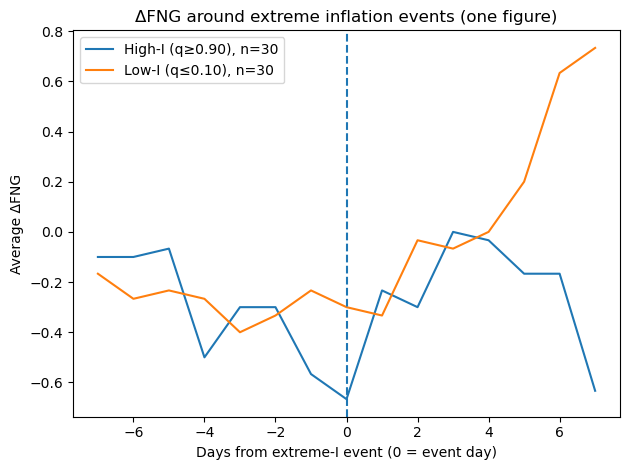

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_onefig_event_fng_around_extreme_I(df, hi_q=0.90, lo_q=0.10, window=3, winsor=(0.01,0.99)):
    d = df.copy()
    if "date" in d.columns and not isinstance(d.index, pd.DatetimeIndex):
        d["date"] = pd.to_datetime(d["date"], utc=True, errors="coerce")
        d = d.set_index("date")
    d = d.sort_index()[["I","fng"]].dropna()

    # Mild winsorization for stability
    for c in ["I","fng"]:
        lo, hi = d[c].quantile(winsor)
        d[c] = d[c].clip(lo, hi)

    d["dFNG"] = d["fng"].diff()
    d = d.dropna()

    hi_thr = float(d["I"].quantile(hi_q))
    lo_thr = float(d["I"].quantile(lo_q))
    d["ext_highI"] = (d["I"] >= hi_thr).astype(int)
    d["ext_lowI"]  = (d["I"] <= lo_thr).astype(int)

    def collect_windows(series, event_idx, pre, post):
        mats = []
        for dt in event_idx:
            if dt not in series.index: 
                continue
            loc = series.index.get_loc(dt)
            if isinstance(loc, slice): 
                loc = loc.start
            if loc-pre < 0 or loc+post >= len(series):
                continue
            w = series.iloc[loc-pre:loc+post+1].to_numpy()
            mats.append(w)
        return np.vstack(mats) if mats else np.empty((0, pre+post+1))

    pre = post = int(window)
    fear_like = collect_windows(d["dFNG"], d.index[d["ext_lowI"]==1], pre, post)   # low-I events
    greed_like = collect_windows(d["dFNG"], d.index[d["ext_highI"]==1], pre, post) # high-I events

    x = np.arange(-pre, post+1)
    plt.figure()
    if greed_like.size:
        plt.plot(x, np.nanmean(greed_like, axis=0), label=f"High-I (q≥{hi_q:.2f}), n={greed_like.shape[0]}")
    if fear_like.size:
        plt.plot(x, np.nanmean(fear_like, axis=0), label=f"Low-I (q≤{lo_q:.2f}), n={fear_like.shape[0]}")
    plt.axvline(0, linestyle="--")
    plt.xlabel("Days from extreme-I event (0 = event day)")
    plt.ylabel("Average ΔFNG")
    plt.title("ΔFNG around extreme inflation events (one figure)")
    plt.legend()
    plt.tight_layout()
    # plt.show()  # uncomment when running interactively

df = pd.read_csv("DATA.csv")
df = df.rename(columns={'participation-rate': 'B', 'issuance-rate': 'I', 'fear-greed-index': 'fng'})
plot_onefig_event_fng_around_extreme_I(df, hi_q=0.90, lo_q=0.10, window=7)

